# Projet MLA - Partie2
## EXPLAINING AND HARNESSING ADVERSARIAL EXAMPLES

In [13]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [18]:
import importlib
import multiDataEval

importlib.reload(multiDataEval)

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# propre : from multiDataEval import mdp , et on apppelle mdp.espilon ds le code 
from multiDataEval import main, plot_comparison, local_linearity, datasets_info
from multiDataEval import test_batch_size
from multiDataEval import show_adversarial_examples, show_pgd_examples
from multiDataEval import epsilon, device, n_visual
from multiDataEval import test_model_adversarial_pgd

Using device: cuda


In [19]:
models, results, loaders = main()


=== Dataset: MNIST ===
 Training clean...
  Epoch 1/1 - loss: 0.1805, acc: 0.9460 (took 6.6s)
 Results (clean model) -> Clean Acc: 0.9852, Adv Acc: 0.1410
 Training adversarial...
  [adv train] batch 100/469
  [adv train] batch 200/469
  [adv train] batch 300/469
  [adv train] batch 400/469
  Epoch 1/1 - loss: 0.5489, clean-acc: 0.9332 (took 8.1s)
 Results (adv model) -> Clean Acc: 0.9782, Adv Acc: 0.8571
 Results (clean model) -> Clean Acc: 0.9852, FGSM Acc: 0.1410, PGD Acc: 0.0009
 Results (adv model) -> Clean Acc: 0.9782, FGSM Acc: 0.8571, PGD Acc: 0.4180

=== Dataset: Fashion-MNIST ===
 Training clean...
  Epoch 1/1 - loss: 0.4339, acc: 0.8465 (took 6.4s)
 Results (clean model) -> Clean Acc: 0.8750, Adv Acc: 0.0040
 Training adversarial...
  [adv train] batch 100/469
  [adv train] batch 200/469
  [adv train] batch 300/469
  [adv train] batch 400/469
  Epoch 1/1 - loss: 0.7491, clean-acc: 0.7821 (took 8.1s)
 Results (adv model) -> Clean Acc: 0.8305, Adv Acc: 0.8497
 Results (clean 

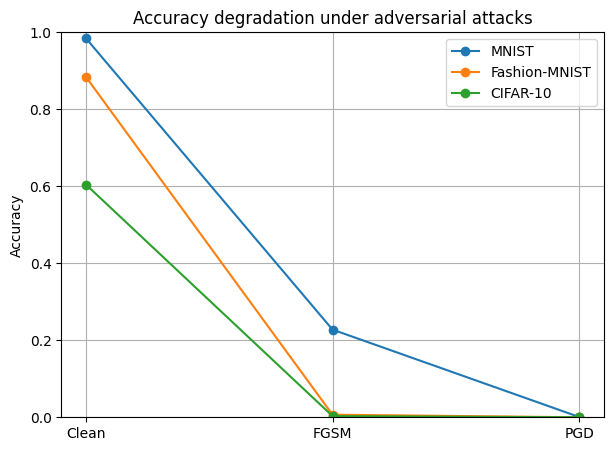

In [34]:
# Visu globale
plot_comparison({
    k: {
        'clean': v['clean'],
        'fgsm': v['fgsm'],
        'pgd': v['pgd']
    }
    for k, v in results.items()
})

## Pour aller plus loin
Les expériences confirment que la linéarité locale est la principale cause de vulnérabilité des réseaux de neurones, tandis que l’introduction de non-linéarités locales (comme dans les modèles RBF) peut améliorer la robustesse. Les techniques classiques d’optimisation ou de régularisation offrent peu d’efficacité, et seul l’entraînement contradictoire montre des résultats significatifs, mais à coût élevé.

Nous allons approfondir l’étude de la linéarité locale sur plusieurs datasets et évaluer la robustesse adversariale à l’aide d’analyses PGD.

### 1 Étude de la linéarité locale pour plusieurs datasets

Nous allons mesurer la linéarité locale des logits pour différents modèles entraînés dans le notebook (`SimpleCNN` sur MNIST, Fashion-MNIST et CIFAR-10).  
L’objectif est de quantifier si la linéarité locale corrèle avec la vulnérabilité aux attaques FGSM/PGD.

In [20]:
lin_results = {}

for dataset_name, model_dict in models.items():
    print(f"\n=== Dataset: {dataset_name} ===")
    
    # loader test
    info = datasets_info[dataset_name]
    test_dataset = info["dataset"](root="./data", train=False, download=True, transform=info["transform"])
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    
    lin_results[dataset_name] = {}
    for model_type, model in model_dict.items():
        lin = local_linearity(model, test_loader, epsilon=0.01, n_samples=200)
        lin_results[dataset_name][model_type] = lin
        print(f"{model_type} model - local linearity: {lin:.4f}")


=== Dataset: MNIST ===
clean model - local linearity: 8.3633
adv model - local linearity: 7.6109

=== Dataset: Fashion-MNIST ===
clean model - local linearity: 13.2396
adv model - local linearity: 17.8741

=== Dataset: CIFAR-10 ===
Files already downloaded and verified
clean model - local linearity: 6.9936
adv model - local linearity: 3.9575


#### 1.1 Visualisation comparée

On peut tracer la linéarité locale pour chaque dataset et type de modèle afin de comparer l'effet de l’adversarial training.

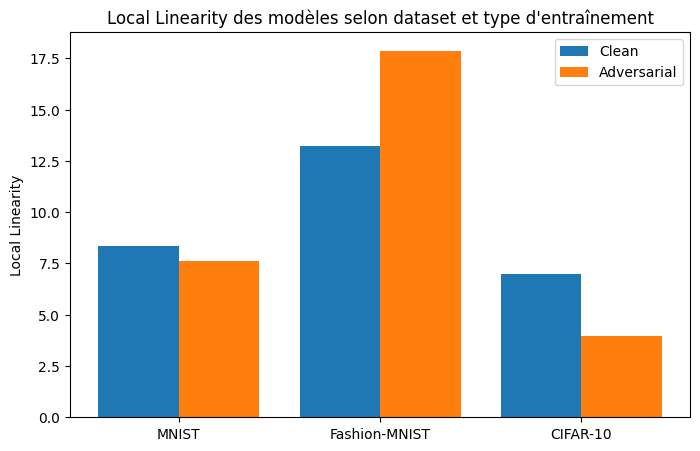

In [25]:
import matplotlib.pyplot as plt

datasets_list = list(lin_results.keys())
x = range(len(datasets_list))

lin_clean = [lin_results[d]["clean"] for d in datasets_list]
lin_adv = [lin_results[d]["adv"] for d in datasets_list]

plt.figure(figsize=(8,5))
plt.bar(x, lin_clean, width=0.4, label='Clean', align='center')
plt.bar([i+0.4 for i in x], lin_adv, width=0.4, label='Adversarial', align='center')
plt.xticks([i+0.2 for i in x], datasets_list)
plt.ylabel("Local Linearity")
plt.title("Local Linearity des modèles selon dataset et type d'entraînement")
plt.legend()
plt.show()

Nos mesures confirment que la linéarité locale est un indicateur quantitatif pertinent de la vulnérabilité adversariale. Cette vulnérabilité est indépendante du dataset, mais dépend fortement de la structure du modèle.
la linéarité locale peut se voir réduite par l’adversarial training, mais peut aussi, dans certains cas, être renforcée grâce à lui.

### 1.2 Analyse des résultats
Dans le contexte de l'article, les comportements observés sur le fichier de réimplémentation 'maxouts.ipynb' correspondent à des valeurs élevées de linéarité locale, expliquant leur vulnérabilité extrême.
Aussi, la réimplémentation des tests sur réseaux RBF montreque par leur structure localement non linéaire et saturante, ceux-ci présentent naturellement une linéarité locale plus faible, ce qui explique leur meilleure robustesse et leur faible confiance hors distribution.
Enfin, la reproduction de l'expérience de la section 9 de l'article, indique que les ensembles de modèles ne modifient pas fondamentalement la linéarité locale, car ils combinent des fonctions qui restent exploitables par des attaques basées sur le gradient.

Ainsi, nos mesures confirment que la linéarité locale est un indicateur quantitatif pertinent de la vulnérabilité adversariale. Cette vulnérabilité est indépendante du dataset, mais dépend fortement de la structure du modèle.
la linéarité locale peut se voir réduite par l’adversarial training, mais peut aussi, dans certains cas, être renforcée grâce à lui.

### 2.1 Hypothèse

Si la vulnérabilité des réseaux est due à une linéarité locale exploitable,
alors un modèle entraîné uniquement sur données propres échouera face à PGD. En revanche, un modèle entraîné adversarialement montrera une meilleure résistance, des perturbations visuellement plus structurées et une réduction de la linéarité locale effective.

### 2 Robustesse adversariale avancée : analyse par PGD

Dans cette section, nous concentrons l’analyse sur l’attaque PGD (Projected Gradient Descent), considérée comme l’attaque de référence en robustesse adversariale.

Contrairement à FGSM, PGD explore une région locale autour de l’entrée via plusieurs itérations,ce qui en fait une approximation du pire cas local.

### 2.1 Attaque PGD sur MNIST

En itérant la mise à jour adversariale dans une boule de rayon ε, PGD approxime l’attaque au pire cas autour de chaque échantillon, ce qui en fait un test de robustesse bien plus sévère que FGSM ; c’est précisément pour cette raison que l’on entraîne les modèles avec PGD, afin de forcer la frontière de décision à devenir localement stable face aux perturbations les plus défavorables.

FGSM examples (ε = 0.25 )


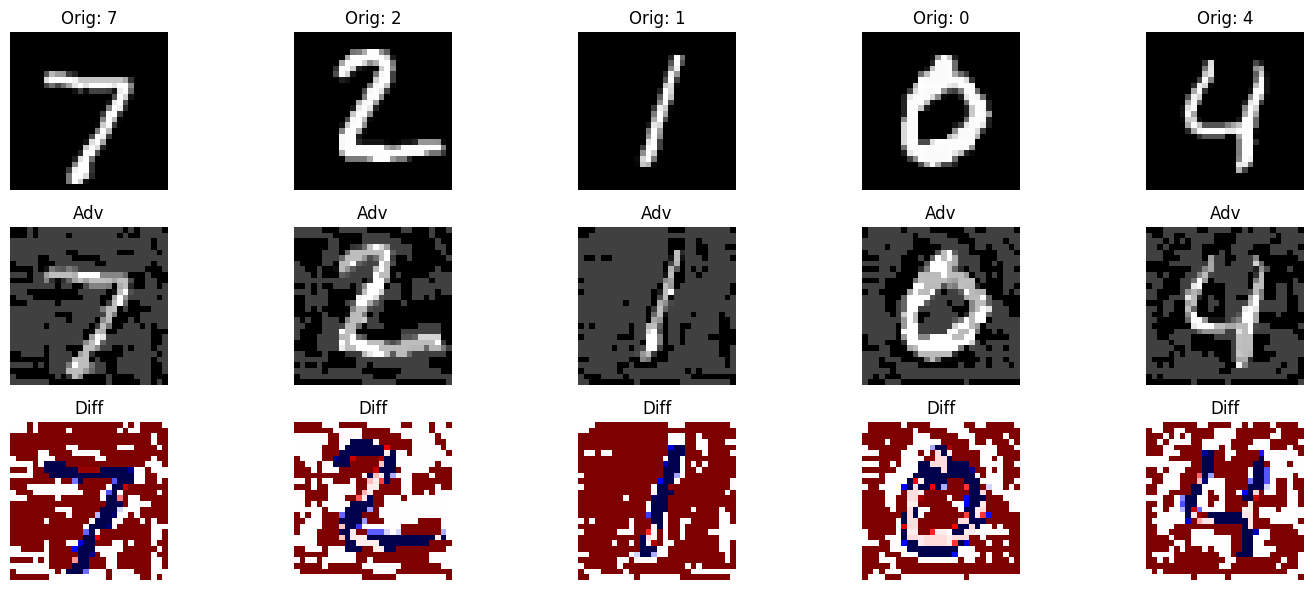

PGD examples (ε = 0.25 , α = 0.025 , iters = 10 )


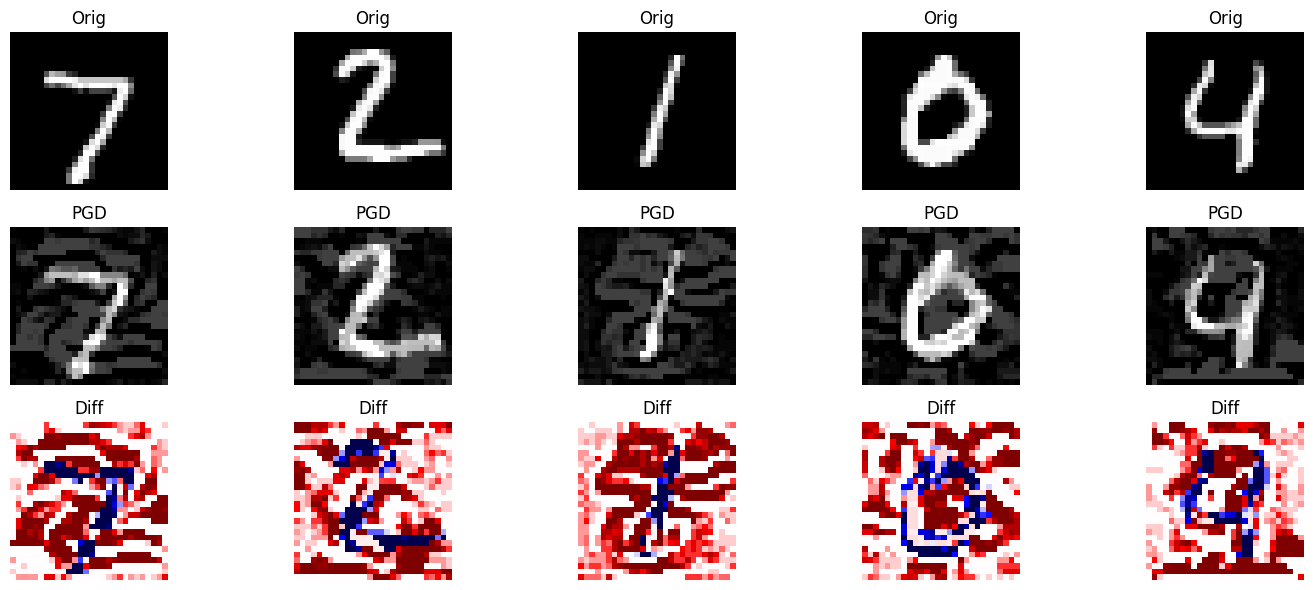

In [34]:
dataset = "MNIST"

# récupérer modèle et loader déjà entraînés
model = models[dataset]["clean"]
test_loader = loaders[dataset]["test"]

print("FGSM examples (ε =", epsilon, ")")
show_adversarial_examples(
    model,
    test_loader,
    epsilon=epsilon,
    device=device,
    n=n_visual
)

print("PGD examples (ε =", epsilon, ", α =", epsilon/10, ", iters = 10 )")
show_pgd_examples(
    model,
    test_loader,
    epsilon=epsilon,
    alpha=epsilon/10,
    num_iter=10,
    device=device,
    n=n_visual
)


Après génération des exemples adversariaux sur le dataset MNIST, on observe que les images perturbées restent visuellement très proches des chiffres originaux, mais que le modèle les classe incorrectement. Les différences de couleur permettent d’interpréter les perturbations : les zones bleues correspondent à des diminutions de valeur de pixel, les zones rouges à des augmentations, et les zones blanches indiquent peu ou pas de changement. 
Une première observation est qu'on observe moins de changements sur la différence entre Original et PGD que sur la différence Original et FGSM. 

En comparant les deux méthodes, FGSM applique une perturbation en un seul pas, générant un bruit simple mais souvent suffisant pour tromper le modèle, tandis que PGD effectue des mises à jour itératives, produisant des perturbations plus structurées et généralement plus efficaces pour provoquer une mauvaise classification.

### 2.2 Variation de epsilon et alpha sur MNIST
Afin d'étudier les rôles des hyperparamètres nous souhaitons observer à partir de quel ε la robustesse s’effondre et comprendre comprendre le compromis entre force de l’attaque et imperceptibilité.

In [26]:
epsilons = [0.05, 0.1, 0.2, 0.3]
alphas = [0.01, 0.02, 0.05]

mnist_results = {}

dataset_name = "MNIST"
test_loader = loaders[dataset_name]["test"]
model = models[dataset_name]["clean"]

for eps in epsilons:
    mnist_results[eps] = {}
    for alpha in alphas:
        acc = test_model_adversarial_pgd(
            model,
            test_loader,
            epsilon=eps,
            alpha=alpha,
            num_iter=10,
            device=device
        )
        mnist_results[eps][alpha] = acc
        print(f"MNIST | ε={eps} α={alpha} → PGD acc = {acc:.4f}")


MNIST | ε=0.05 α=0.01 → PGD acc = 0.9460
MNIST | ε=0.05 α=0.02 → PGD acc = 0.9464
MNIST | ε=0.05 α=0.05 → PGD acc = 0.9508
MNIST | ε=0.1 α=0.01 → PGD acc = 0.8131
MNIST | ε=0.1 α=0.02 → PGD acc = 0.7930
MNIST | ε=0.1 α=0.05 → PGD acc = 0.8021
MNIST | ε=0.2 α=0.01 → PGD acc = 0.8109
MNIST | ε=0.2 α=0.02 → PGD acc = 0.0525
MNIST | ε=0.2 α=0.05 → PGD acc = 0.0202
MNIST | ε=0.3 α=0.01 → PGD acc = 0.8120
MNIST | ε=0.3 α=0.02 → PGD acc = 0.0511
MNIST | ε=0.3 α=0.05 → PGD acc = 0.0000


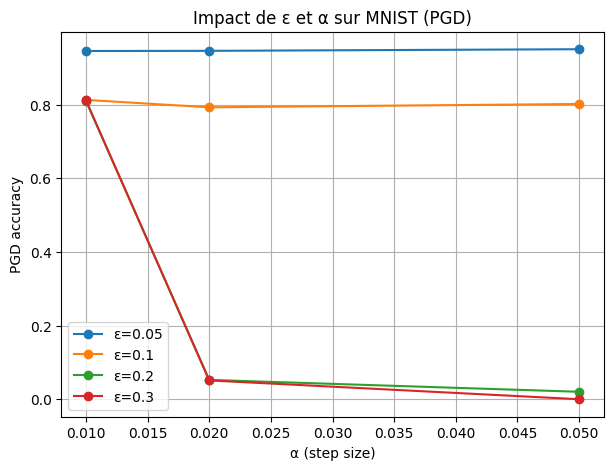

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
for eps in epsilons:
    accs = [mnist_results[eps][a] for a in alphas]
    plt.plot(alphas, accs, marker='o', label=f"ε={eps}")

plt.xlabel("α (step size)")
plt.ylabel("PGD accuracy")
plt.title("Impact de ε et α sur MNIST (PGD)")
plt.legend()
plt.grid(True)
plt.show()

On observe que lorsque pour ε faible (0.05), la précision PGD reste proche de la précision propre et varie peu avec α, alors qu’à partir de ε ≥ 0.1, l’augmentation de α fait chuter brutalement la précision, révélant que la vulnérabilité du modèle est surtout exploitée lorsque PGD peut effectuer une descente de gradient suffisamment agressive dans une région de perturbation plus large.

La précision devient quasi nulle dès que ε atteint 0.2, surtout pour des α ≥ 0.02, ce qui montre que la taille de la perturbation domine totalement l’efficacité de l’attaque, tandis que pour ε ≤ 0.1, le modèle conserve encore une précision relativement élevée quel que soit α.

Donc ε ≈ 0.15–0.20 est la “zone critique”, car c’est là que la géométrie locale est révélée par PGD.

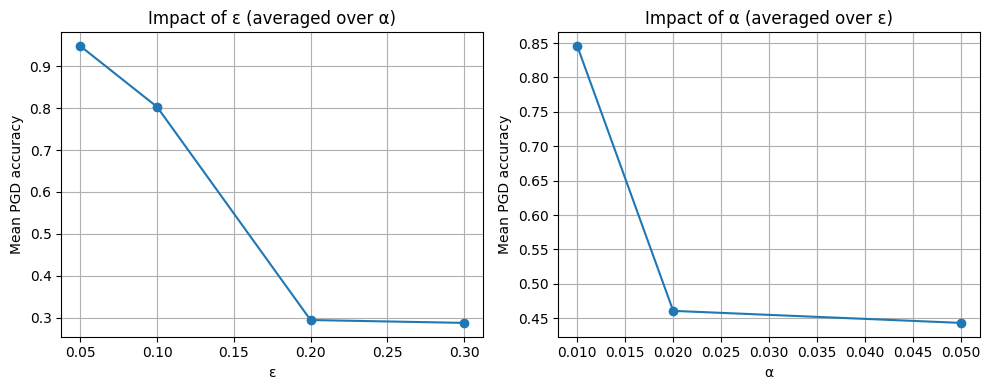

In [31]:
import numpy as np

# Tris pour avoir des axes ordonnés
epsilons_sorted = sorted(epsilons)
alphas_sorted = sorted(alphas)

# Moyenne sur alpha → effet de epsilon
eps_effect = {eps: np.mean(list(mnist_results[eps].values())) for eps in epsilons_sorted}

# Moyenne sur epsilon → effet de alpha
alpha_effect = {}
for alpha in alphas_sorted:
    alpha_effect[alpha] = np.mean([mnist_results[eps][alpha] for eps in epsilons_sorted])

plt.figure(figsize=(10,4))

# ε
plt.subplot(1,2,1)
plt.plot(epsilons_sorted, list(eps_effect.values()), marker="o")
plt.xlabel("ε")
plt.ylabel("Mean PGD accuracy")
plt.title("Impact of ε (averaged over α)")
plt.grid(True)

# α
plt.subplot(1,2,2)
plt.plot(alphas_sorted, list(alpha_effect.values()), marker="o")
plt.xlabel("α")
plt.ylabel("Mean PGD accuracy")
plt.title("Impact of α (averaged over ε)")
plt.grid(True)

plt.tight_layout()
plt.show()

Les moyennes de précision PGD mettent en évidence que ε domine globalement l’impact sur la vulnérabilité, tandis que α affine l’efficacité de l’attaque : un ε élevé réduit fortement la précision moyenne, et parmi ces ε élevés, des α plus grands accélèrent la chute, montrant que les deux hyperparamètres sont essentiels pour évaluer la robustesse.

Après avoir analysé l’impact de ε et α sur MNIST, qui reste particulièrement vulnérable en raison de sa faible dimension, de gradients stables et de la forte régularité des chiffres, nous souhaitons maintenant étendre cette étude pour évaluer la vulnérabilité des modèles sur d’autres datasets plus complexes et variés.

### 2.3 PGD sur d'autres datasets : généralisation de la vulnérabilité
Nous étendons maintenant l’analyse à d’autres datasets
(Fashion-MNIST et CIFAR-10) afin de vérifier si la vulnérabilité observée sur MNIST est spécifique au dataset ou si elle reflète une propriété plus générale des réseaux neuronaux en haute dimension.

Dataset : MNIST
PGD examples (ε = 0.25 , α = 0.025 , iters = 10 )


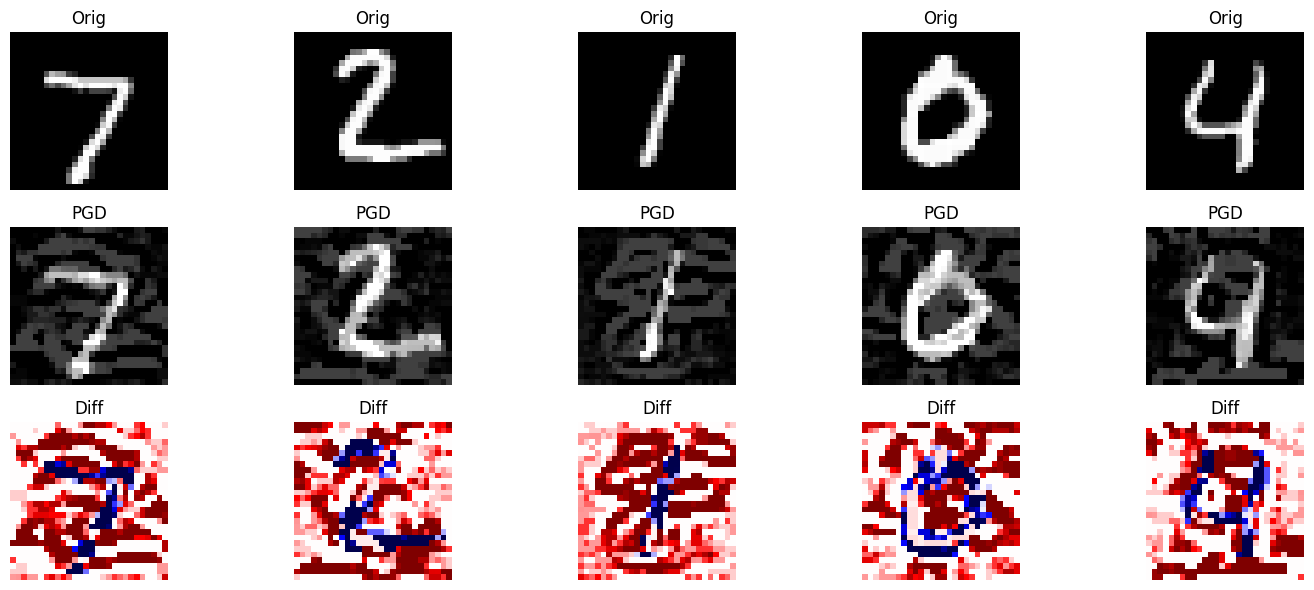

Dataset : Fashion-MNIST
PGD examples (ε = 0.25 , α = 0.025 , iters = 10 )


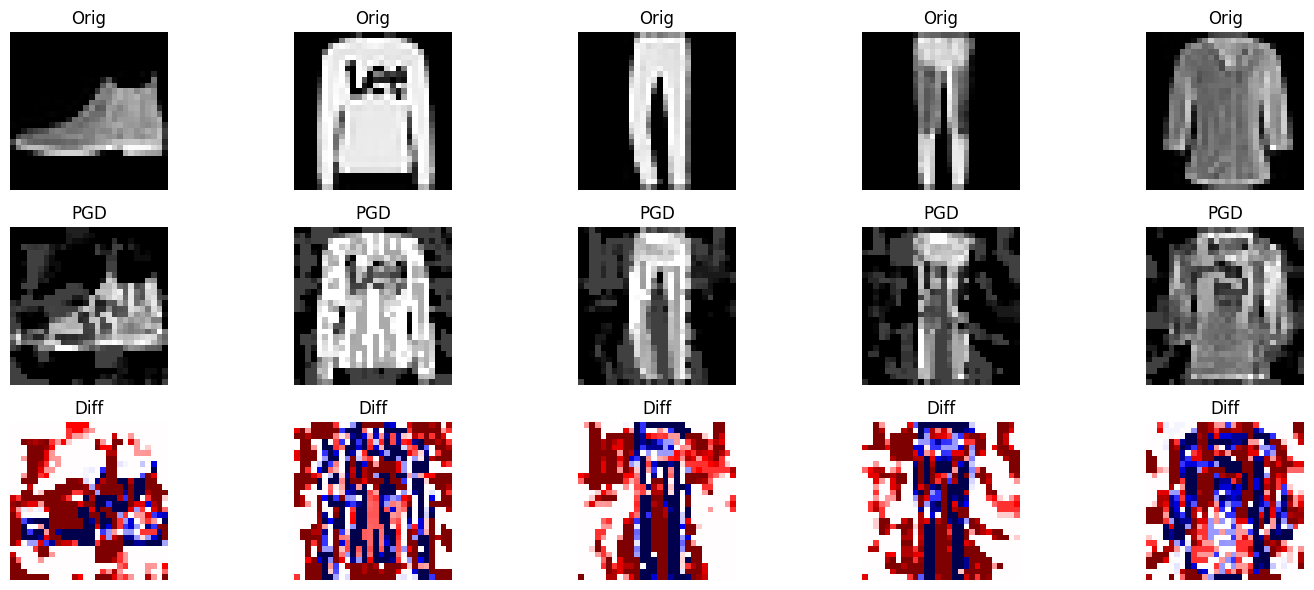

Dataset : CIFAR-10
PGD examples (ε = 0.25 , α = 0.025 , iters = 10 )


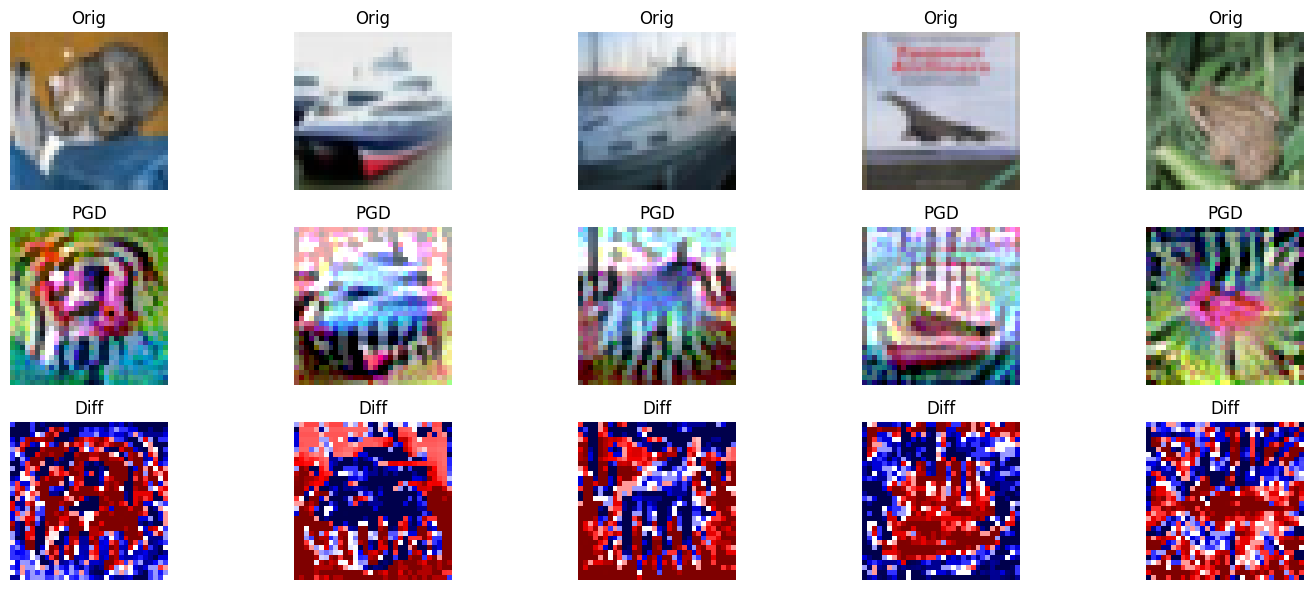

In [52]:
# Visualisation du PGD sur différents datasets
for dataset in ["MNIST", "Fashion-MNIST", "CIFAR-10"]:
    print("Dataset :", dataset)
    
    model = models[dataset]["clean"]
    test_loader = loaders[dataset]["test"]

    # PGD
    print("PGD examples (ε =", epsilon, ", α =", epsilon/10, ", iters = 10 )")
    show_pgd_examples(
        model,
        test_loader,
        epsilon=epsilon,
        alpha=epsilon/10,
        num_iter=10,
        device=device,
        n=n_visual
    )

La visualisation du PGD sur les trois datasets nous permet une première observation : on remarque une forte présence de blanc sur les visualisations de différences MNIST et Fashion-MNIST, et très peu sur CIFAR-10. 

On peut interpréter cette observation ainsi : pour MNIST et Fashion-MNIST, la forte présence de blanc indique que la majorité des pixels subissent peu ou pas de modification, ce qui montre que l’attaque PGD exploite efficacement seulement une petite fraction des pixels pour provoquer des erreurs. En revanche, sur CIFAR‑10, la quasi-absence de blanc et la dominance des zones rouges et bleues révèlent que les perturbations doivent affecter de manière plus diffuse les trois canaux de couleur pour réussir l’attaque, ce qui traduit une géométrie locale plus complexe et moins linéaire que pour les datasets monochromes.

In [51]:
datasets_to_test = ["MNIST", "Fashion-MNIST", "CIFAR-10"]
epsilons = [0.05, 0.1, 0.25]

pgd_multi_results = {}

for dataset in datasets_to_test:
    print(f"\n=== {dataset} ===")
    test_loader = loaders[dataset]["test"]
    model = models[dataset]["clean"]
    pgd_multi_results[dataset] = []

    for eps in epsilons:
        acc = test_model_adversarial_pgd(
            model,
            test_loader,
            epsilon=eps,
            alpha=eps / 10,
            num_iter=10,
            device=device
        )
        pgd_multi_results[dataset].append(acc)
        print(f"ε={eps} → PGD acc = {acc:.4f}")


=== MNIST ===
ε=0.05 → PGD acc = 0.9490
ε=0.1 → PGD acc = 0.8132
ε=0.25 → PGD acc = 0.0009

=== Fashion-MNIST ===
ε=0.05 → PGD acc = 0.4054
ε=0.1 → PGD acc = 0.0857
ε=0.25 → PGD acc = 0.0000

=== CIFAR-10 ===
ε=0.05 → PGD acc = 0.0117
ε=0.1 → PGD acc = 0.0001
ε=0.25 → PGD acc = 0.0000


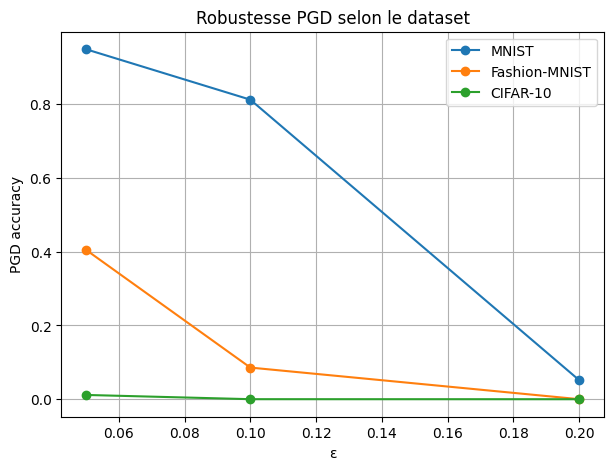

In [33]:
# Comparaison entre les datasets
plt.figure(figsize=(7,5))

for dataset in datasets_to_test:
    plt.plot(
        epsilons,
        pgd_multi_results[dataset],
        marker='o',
        label=dataset
    )

plt.xlabel("ε")
plt.ylabel("PGD accuracy")
plt.title("Robustesse PGD selon le dataset")
plt.legend()
plt.grid(True)
plt.show()

La robustesse des modèles décroît rapidement avec l’augmentation de l’amplitude des perturbations adversariales : sur MNIST, l’accuracy chute progressivement, tandis que sur Fashion-MNIST et CIFAR-10, elle devient quasi nulle dès ε=0.1. Cela illustre que même des perturbations modestes suffisent à compromettre fortement les performances, en particulier sur des datasets plus complexes ou plus sensibles.

On observe un point de transition brutal dans le comportement du modèle face aux attaques PGD : pour des perturbations faibles (ε ≤ 0,10), le modèle conserve une précision élevée et résiste efficacement, tandis que pour des perturbations plus importantes (ε ≥ 0,20), il entre dans une zone instable où la précision chute fortement, cette chute étant alors très sensible à la valeur du pas α. Ainsi, la zone critique se situe autour de ε ≈ 0,15–0,20, correspondant à l’échelle de perturbation où la géométrie locale du modèle est pleinement révélée par PGD.

Les résultats montrent que tous les datasets subissent une dégradation significative sous PGD. Particulièrement CIFAR-10 qui est encore plus sensible car sur une dimension plus élevée, on observe des gradients plus dispersés et des perturbations imperceptibles mais très efficaces.

Cela confirme que la vulnérabilité aux attaques adversariales n’est pas liée au dataset mais à la linéarité locale des modèles en haute dimension.
Le PGD constitue un test de robustesse bien plus sévère que le FGSM : ε et α doivent être ajustés en fonction du dataset, mais aucun d’entre eux n’échappe au phénomène fondamental de vulnérabilité lié à la linéarité locale des réseaux de neurones. Le PGD révèle une vulnérabilité universelle, indépendante du dataset.

Pour la suite, on concentre notre étude sur MNIST et fashion-MNIST compte tenu de nos précédents résultats.

### 2.3 Analyse locale par variation de α
L’étude basée uniquement sur ε est limitée par l’échelle propre à chaque dataset, ce qui motive l’analyse complémentaire par variation de α afin de sonder plus finement la géométrie et la linéarité locale des modèles.

#### On fixe ε raisonnable
Les valeurs de ε utilisées pour l’analyse de α ont été choisies empiriquement à partir des courbes PGD accuracy(ε), en sélectionnant des rayons situés dans la zone de transition entre robustesse et effondrement de la précision. Cette zone correspond au voisinage immédiat de la frontière de décision, là où la géométrie locale du modèle est effectivement sondée par PGD. Fixer ε dans cette plage garantit que la variation de la précision en fonction de α reflète bien la linéarité locale du réseau plutôt qu’un effet de sous- ou sur-perturbation.

In [53]:
epsilons = {
    "MNIST": 0.25,
    "Fashion-MNIST": 0.25
}

#### Exploration de alpha

In [54]:
alphas = [0.002, 0.005, 0.01, 0.02, 0.05, 0.1]


#### Calcul de pgd accuracy pour alpha

In [55]:
pgd_alpha_results = {}

for dataset in ["MNIST", "Fashion-MNIST"]:
    print(f"\n=== {dataset} ===")
    model = models[dataset]["clean"]
    loader = loaders[dataset]["test"]
    epsilon = epsilons[dataset]

    pgd_alpha_results[dataset] = []

    for alpha in alphas:
        acc = test_model_adversarial_pgd(
            model,
            loader,
            epsilon=epsilon,
            alpha=alpha,
            num_iter=10,
            device=device
        )
        pgd_alpha_results[dataset].append(acc)
        print(f"α={alpha:.3f} → PGD acc = {acc:.4f}")



=== MNIST ===
α=0.002 → PGD acc = 0.9769
α=0.005 → PGD acc = 0.9483
α=0.010 → PGD acc = 0.8112
α=0.020 → PGD acc = 0.0505
α=0.050 → PGD acc = 0.0003
α=0.100 → PGD acc = 0.0003

=== Fashion-MNIST ===
α=0.002 → PGD acc = 0.7198
α=0.005 → PGD acc = 0.4011
α=0.010 → PGD acc = 0.0848
α=0.020 → PGD acc = 0.0001
α=0.050 → PGD acc = 0.0000
α=0.100 → PGD acc = 0.0000


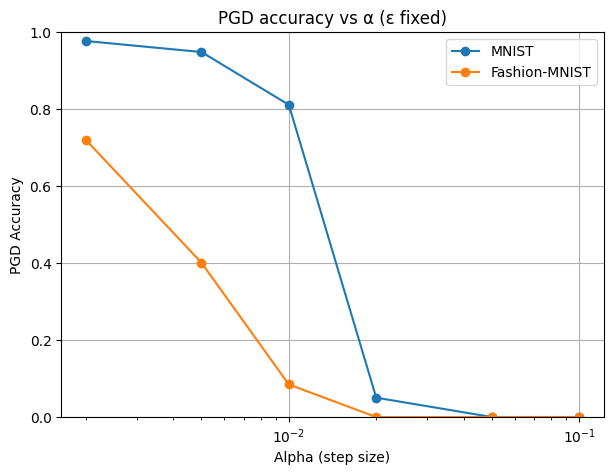

In [56]:
# Visualisation pente et linéarité 
plt.figure(figsize=(7,5))

for dataset, accs in pgd_alpha_results.items():
    plt.plot(alphas, accs, marker="o", label=dataset)

plt.xlabel("Alpha (step size)")
plt.ylabel("PGD Accuracy")
plt.title("PGD accuracy vs α (ε fixed)")
plt.xscale("log")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

Les valeurs montrent une chute extrêmement rapide de la précision lorsque α augmente. Sur MNIST, la PGD accuracy passe de 97,7 % à α=0.002 à quasiment 0 % dès α≥0.05, tandis que sur Fashion-MNIST la dégradation est encore plus brutale, avec une précision déjà divisée par deux à α=0.005 et quasi nulle à α=0.02. 

Cette dynamique est exactement ce que révèle la courbe accuracy = f(α) : la pente de cette courbe est une signature directe de la linéarité locale du modèle, car une chute rapide signifie que de petits pas de gradient suffisent à parcourir efficacement la frontière de décision et à exploiter sa structure quasi linéaire. 

Ainsi, faire varier α à ε fixé permet de sonder beaucoup plus finement la géométrie locale du réseau : un modèle réellement non linéaire résisterait à l’augmentation de α, alors que la sensibilité observée ici confirme que MNIST et Fashion-MNIST restent dominés par une géométrie localement linéaire, hautement exploitable par PGD.

### 3. Conclusion

La robustesse n’est pas une propriété du modèle seul, ni de l’attaque seule, mais de l’interaction entre la géométrie du dataset et la linéarité locale du réseau
